In [1]:
# Reference code: https://medium.com/@aungkyawmyint_26195/multi-layer-perceptron-mnist-pytorch-463f795b897a
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from google.colab import files

In [108]:
torch.set_default_dtype(torch.float64)

In [109]:
# Hyperparameters 

epochs = 20
batch_size = 64
valid_size = 0.2 
learning_rate = 0.00005 # optimizer parameter
momentum = 0.9 # optimizer parameter 
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False # turned off the nondeterministic algo used in cuDNN
# For repeatable experiments, set random seeds for anything using random number generation (numpy and random)
torch.manual_seed(random_seed) 

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2
# convert data to torch.FloatTensor
transform = transforms.ToTensor() 
# choose the training and testing datasets
train_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)

In [110]:
# Set up Dataloaders

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_index, valid_index = indices[split:], indices[:split]
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)
# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, 
                                           sampler = train_sampler, num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                          sampler = valid_sampler, num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size,
                                         num_workers = num_workers)

(20, 1, 28, 28)


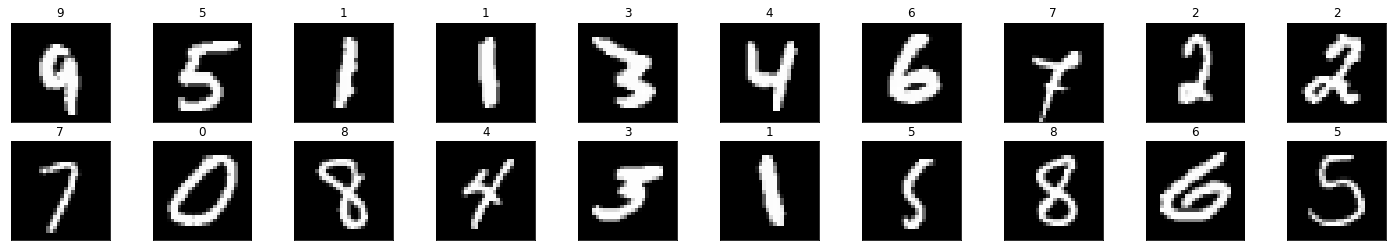

In [111]:
# Show example images 

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
print(images.shape)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

<class 'numpy.float64'>


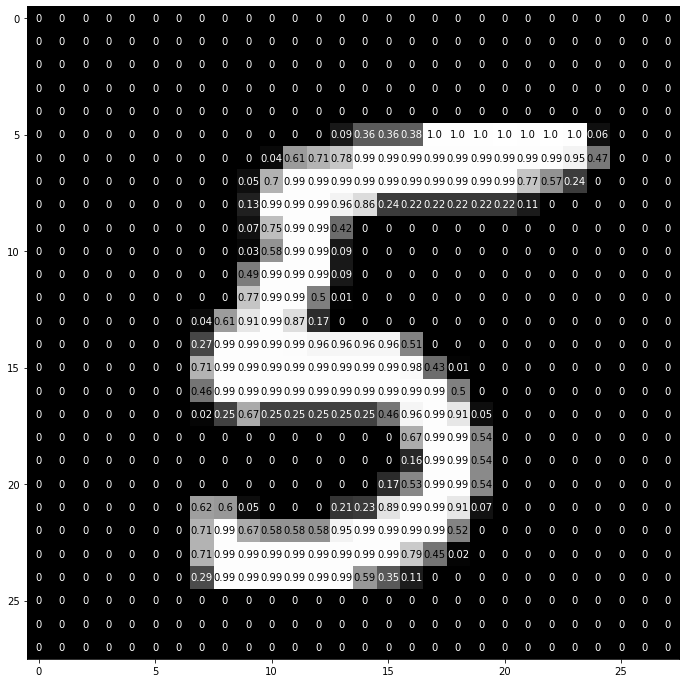

In [112]:
# Show an image in detail 

img = np.squeeze(images[1])
print(type(img[0][0])) # float32: sign bit, 8 bits exponent, 23 bits mantissa
fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

In [25]:
# Define MLP architecture

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        # number of hidden nodes in each layer (512)
        hidden_1 = 512
        hidden_2 = 512
        # linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(28*28, 512)      # parameters and weights = torch.float32 (32 bits but exact fixed point not sure)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(512,512)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(512,10)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.droput = nn.Dropout(0.2)         # no dropout in the eval() mode (no impact in hw)
        
    def forward(self,x):
        # flatten image input
        x = x.view(-1,28*28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.droput(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.droput(x)
        # add output layer
        x = self.fc3(x)
        return x
        
# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (droput): Dropout(p=0.2, inplace=False)
)


In [113]:
# Define MLP architecture

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        # number of hidden nodes in each layer (512)
        hidden_1 = 512
        hidden_2 = 512
        # linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(28*28, 512)      # parameters and weights = torch.float32 (32 bits but exact fixed point not sure)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(512,512)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(512,10)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.droput = nn.Dropout(0.2)         # no dropout in the eval() mode (no impact in hw)
        tensor = torch.ones(())
        self.x = tensor.new_empty((20, 1, 28, 28))
        self.y = tensor.new_empty((20, 784))
        self.z = tensor.new_empty((20, 512))
        self.k = tensor.new_empty((20, 512))
        self.l = tensor.new_empty((20, 512))
        self.m = tensor.new_empty((20, 512))
        self.n = tensor.new_empty((20, 10))
        
    def forward(self,x):
        # flatten image input
        self.x = x
        x = x.view(-1,28*28)
        self.y = x
        # add hidden layer, with relu activation function
        x = self.fc1(x)
        self.z = x
        x = F.relu(x)
        self.k = x
        # add dropout layer
        x = self.droput(x)
        # add hidden layer, with relu activation function
        x = self.fc2(x) 
        self.l = x
        x = F.relu(self.fc2(x))
        self.m = x
        # add dropout layer
        x = self.droput(x)
        # add output layer
        x = self.fc3(x)
        self.n = x
        return x
        
# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (droput): Dropout(p=0.2, inplace=False)
)


In [ ]:
# Define MLP architecture

class Net_debugging(nn.Module):
    def __init__(self):
        super(Net_debugging,self).__init__()
        # linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(28*28, 10)
        
    def forward(self,x):
        # flatten image input
        x = x.view(-1,28*28)
        # add hidden layer, with relu activation function
        x = self.fc1(x)
        return x
        
# initialize the NN
model = Net_debugging()
print(model)

Net_debugging(
  (fc1): Linear(in_features=784, out_features=10, bias=True)
)


In [114]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()
# specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)

In [115]:
# number of epochs to train the model
n_epochs = 15

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf  # set initial "min" to infinity


# for epoch in range(n_epochs):
for epoch in range(n_epochs):
    # monitor losses
    train_loss = 0
    valid_loss = 0
    
     
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data,label in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output,label)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item() * data.size(0)
        
        
     ######################    
    # validate the model #
    ######################
    model.eval()  # prep model for evaluation
    for data,label in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output,label)
        # update running validation loss 
        valid_loss = loss.item() * data.size(0)
    
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.046275 	Validation Loss: 0.000817
Validation loss decreased (inf --> 0.000817).  Saving model ...
Epoch: 2 	Training Loss: 0.347460 	Validation Loss: 0.000828
Epoch: 3 	Training Loss: 0.252362 	Validation Loss: 0.000077
Validation loss decreased (0.000817 --> 0.000077).  Saving model ...
Epoch: 4 	Training Loss: 0.194734 	Validation Loss: 0.000245
Epoch: 5 	Training Loss: 0.157409 	Validation Loss: 0.000069
Validation loss decreased (0.000077 --> 0.000069).  Saving model ...
Epoch: 6 	Training Loss: 0.131711 	Validation Loss: 0.000048
Validation loss decreased (0.000069 --> 0.000048).  Saving model ...
Epoch: 7 	Training Loss: 0.112399 	Validation Loss: 0.000024
Validation loss decreased (0.000048 --> 0.000024).  Saving model ...
Epoch: 8 	Training Loss: 0.097764 	Validation Loss: 0.000233
Epoch: 9 	Training Loss: 0.087020 	Validation Loss: 0.000003
Validation loss decreased (0.000024 --> 0.000003).  Saving model ...
Epoch: 10 	Training Loss: 0.076794 	Valida

In [116]:
# Check last layer of the model -- whether automatically use an activation? no 

model.eval()

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# print(images[0].shape)
# print(type(images[0]))

# get sample outputsx
output = model(images)

print(output) # signed raw 10 float32 outputs
print(type(output))
print(len(output))
# print(output)
print(output.shape)
print(output[0])

tensor([[ -2.5868,  -0.5140,   3.8175,   4.8947,  -6.1448,  -2.1561, -12.5296,
          14.4381,  -0.8246,   2.3507],
        [  0.8338,   3.4989,  12.6833,   3.4877, -10.2162,  -1.5612,   2.5366,
          -3.0921,   2.9151,  -9.2300],
        [ -6.3430,   9.4048,   1.8495,  -0.7682,  -0.4281,  -1.4018,   0.0957,
           1.8513,   1.8735,  -4.2759],
        [ 11.5074,  -6.0686,   2.0376,  -2.4803,  -5.4833,   0.5141,   1.4725,
           0.8494,  -3.0726,   0.7723],
        [ -1.9100,  -3.7035,  -1.5768,  -5.6580,  12.1363,  -1.8938,   0.0711,
           2.5896,  -3.1037,   4.8456],
        [ -8.1080,  12.6279,   1.2084,  -1.1416,   1.8376,  -4.2107,  -2.6863,
           5.0851,   0.5241,  -3.1178],
        [ -5.4748,  -2.1134,  -4.8932,  -5.2344,  11.1672,   1.9614,   0.7934,
          -1.2217,   4.0526,   3.3079],
        [ -4.9122,  -1.6193,   0.2690,   5.6900,   0.3546,  -1.9034,  -8.5247,
           2.2529,   1.5456,   8.5436],
        [ -1.1922,  -3.6466,  -3.2893,  -5.7027,

In [117]:
# print(model.y.shape)
print(model.n[:11].detach().numpy())

[[ -2.58679285  -0.5140171    3.81751358   4.89470186  -6.14480286
   -2.1561424  -12.52957414  14.4381363   -0.82456604   2.35072442]
 [  0.83375197   3.49887138  12.68327641   3.48774131 -10.2161554
   -1.56117424   2.53659554  -3.0921173    2.91514076  -9.23003762]
 [ -6.3430433    9.40479625   1.84946871  -0.76821115  -0.42814543
   -1.40176974   0.09568872   1.85127637   1.87351988  -4.27588535]
 [ 11.50738808  -6.06858827   2.03756473  -2.48025383  -5.48327125
    0.51407987   1.4725119    0.84939482  -3.07255823   0.77231728]
 [ -1.90995401  -3.70351039  -1.57680116  -5.65803318  12.13634055
   -1.89378326   0.07105454   2.58959011  -3.10374812   4.84558596]
 [ -8.10799401  12.62786998   1.20837815  -1.1415695    1.83762048
   -4.2106796   -2.68634529   5.08505586   0.52412243  -3.11779889]
 [ -5.47476098  -2.11336239  -4.89315097  -5.23437031  11.16721603
    1.96142429   0.79341543  -1.22171373   4.05256718   3.30789978]
 [ -4.91218921  -1.61928372   0.26904607   5.68999618   

In [118]:
# Save layerwise outputs

! mkdir save_parameters
! cd save_parameters
fc1_inputs = model.x[:11].detach().numpy().reshape(1, -1)
print(fc1_inputs.shape)
fc1_outputs = model.z[:11].detach().numpy().reshape(1, -1)
print(fc1_outputs.shape)

pd.DataFrame(fc1_inputs).to_csv('fc1_inputs.dat', index=False, header=False)
pd.DataFrame(fc1_outputs).to_csv('fc1_outputs.dat', index=False, header=False)

relu1_outputs = model.k[:11].detach().numpy().reshape(1, -1)  
print(relu1_outputs.shape) 
pd.DataFrame(relu1_outputs).to_csv('relu1_outputs.dat', index=False, header=False)
fc2_outputs = model.l[:11].detach().numpy().reshape(1, -1)
print(fc2_outputs.shape) 
pd.DataFrame(fc2_outputs).to_csv('fc2_outputs.dat', index=False, header=False)

relu2_outputs = model.m[:11].detach().numpy().reshape(1, -1)
print(relu2_outputs.shape) 
pd.DataFrame(relu2_outputs).to_csv('relu2_outputs.dat', index=False, header=False)
fc3_outputs = model.n[:11].detach().numpy().reshape(1, -1)
print(fc3_outputs.shape) 
pd.DataFrame(fc3_outputs).to_csv('fc3_outputs.dat', index=False, header=False)

files.download('fc1_inputs.dat')
files.download('fc1_outputs.dat')

files.download('relu1_outputs.dat')
files.download('fc2_outputs.dat')

files.download('relu2_outputs.dat')
files.download('fc3_outputs.dat')

mkdir: cannot create directory ‘save_parameters’: File exists
(1, 8624)
(1, 5632)
(1, 5632)
(1, 5632)
(1, 5632)
(1, 110)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [119]:
# Check last layer of the model -- whether automatically use an activation? no 

model.eval()

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

print(images[0].shape)
print(type(images[0]))

# get sample outputsx
output = model(images)

# print(output) # signed raw 10 float32 outputs
print(type(output))
print(len(output))
print(output)

# convert output probabilities to predicted class
_, preds = torch.max(output, 1)

print(preds) # 1 integer per image 

# # Save the final layer outputs of the first 11 images

# saved_outputs = output.detach().numpy()[:11] 
# print(saved_outputs.shape)

# pd.DataFrame(saved_outputs).to_csv('single_layer_out_784x10.dat', index=False, header=False)
# files.download('single_layer_out_784x10.dat')

torch.Size([1, 28, 28])
<class 'torch.Tensor'>
<class 'torch.Tensor'>
20
tensor([[ -2.5868,  -0.5140,   3.8175,   4.8947,  -6.1448,  -2.1561, -12.5296,
          14.4381,  -0.8246,   2.3507],
        [  0.8338,   3.4989,  12.6833,   3.4877, -10.2162,  -1.5612,   2.5366,
          -3.0921,   2.9151,  -9.2300],
        [ -6.3430,   9.4048,   1.8495,  -0.7682,  -0.4281,  -1.4018,   0.0957,
           1.8513,   1.8735,  -4.2759],
        [ 11.5074,  -6.0686,   2.0376,  -2.4803,  -5.4833,   0.5141,   1.4725,
           0.8494,  -3.0726,   0.7723],
        [ -1.9100,  -3.7035,  -1.5768,  -5.6580,  12.1363,  -1.8938,   0.0711,
           2.5896,  -3.1037,   4.8456],
        [ -8.1080,  12.6279,   1.2084,  -1.1416,   1.8376,  -4.2107,  -2.6863,
           5.0851,   0.5241,  -3.1178],
        [ -5.4748,  -2.1134,  -4.8932,  -5.2344,  11.1672,   1.9614,   0.7934,
          -1.2217,   4.0526,   3.3079],
        [ -4.9122,  -1.6193,   0.2690,   5.6900,   0.3546,  -1.9034,  -8.5247,
           2.25

In [ ]:
# Save the final layer outputs of the first 11 images

saved_outputs = output.detach().numpy()[:11] 
print(saved_outputs.shape)

pd.DataFrame(saved_outputs).to_csv('single_layer_out_784x10.dat', index=False, header=False)
files.download('single_layer_out_784x10.dat')

In [ ]:
scale = 2 ** 5 
fc1_scaled_weights = model.fc1.weight.detach().numpy() * scale 
fc2_scaled_weights = model.fc2.weight.detach().numpy() * scale 
fc3_scaled_weights = model.fc3.weight.detach().numpy() * scale 

fc1_scaled_bias = model.fc1.bias.detach().numpy() * scale 
fc2_scaled_bias = model.fc2.bias.detach().numpy() * scale 
fc3_scaled_bias = model.fc3.bias.detach().numpy() * scale 

print(model.fc1.weight.detach().numpy())
print(fc1_scaled_weights)

[[ 0.00674902  0.01285053 -0.00294661 ... -0.02314218 -0.0035126
  -0.01272364]
 [-0.01321381 -0.03402835  0.03556682 ... -0.00113082 -0.0307312
   0.0099228 ]
 [-0.02751008 -0.00433029 -0.01651425 ...  0.0103045   0.01623522
   0.00115037]
 ...
 [-0.03237298  0.03165776  0.01300099 ...  0.01930032  0.01010458
  -0.02780359]
 [-0.00793496 -0.0244325  -0.02013677 ...  0.01000587 -0.01867454
  -0.00903092]
 [ 0.01877061  0.00767793 -0.02014781 ... -0.0034211   0.03236701
   0.00389756]]
[[ 0.21596872  0.41121698 -0.09429162 ... -0.74054962 -0.11240314
  -0.40715636]
 [-0.42284192 -1.08890724  1.13813836 ... -0.03618628 -0.98339846
   0.31752971]
 [-0.88032256 -0.1385692  -0.52845596 ...  0.32974416  0.51952692
   0.03681171]
 ...
 [-1.03593546  1.01304835  0.41603169 ...  0.61761029  0.32334649
  -0.88971501]
 [-0.25391869 -0.78184    -0.64437657 ...  0.32018798 -0.59758529
  -0.28898936]
 [ 0.60065952  0.24569373 -0.64472994 ... -0.10947531  1.03574418
   0.12472182]]


In [120]:
# Save raw double weights as dat without reshape 

! mkdir save_parameters
! cd save_parameters

fc1_double_weights = model.fc1.weight.detach().numpy() 
fc2_double_weights = model.fc2.weight.detach().numpy() 
fc3_double_weights = model.fc3.weight.detach().numpy() 

fc1_double_bias = model.fc1.bias.detach().numpy() 
fc2_double_bias = model.fc2.bias.detach().numpy() 
fc3_double_bias = model.fc3.bias.detach().numpy() 


pd.DataFrame(fc1_double_weights).to_csv('fc1_double_weights.dat', index=False, header=False)
pd.DataFrame(fc2_double_weights).to_csv('fc2_double_weights.dat', index=False, header=False)
pd.DataFrame(fc3_double_weights).to_csv('fc3_double_weights.dat', index=False, header=False)

pd.DataFrame(fc1_double_bias).to_csv('fc1_double_bias.dat', index=False, header=False)
pd.DataFrame(fc2_double_bias).to_csv('fc2_double_bias.dat', index=False, header=False)
pd.DataFrame(fc3_double_bias).to_csv('fc3_double_bias.dat', index=False, header=False)

files.download('fc1_double_weights.dat')
files.download('fc1_double_bias.dat')

files.download('fc2_double_weights.dat')
files.download('fc2_double_bias.dat')

files.download('fc3_double_weights.dat')
files.download('fc3_double_bias.dat')

mkdir: cannot create directory ‘save_parameters’: File exists


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [107]:
# Save raw weights as dat 

! mkdir save_parameters
! cd save_parameters
fc1_weights_tmp = model.fc1.weight.detach().numpy().reshape(-1)
fc1_weights = model.fc1.weight.detach().numpy().reshape(1, -1)
print(fc1_weights_tmp)
print(fc1_weights)
pd.DataFrame(fc1_weights).to_csv('fc1_weights.dat', index=False, header=False)
fc1_bias = model.fc1.bias.detach().numpy().reshape(1, -1)
pd.DataFrame(fc1_bias).to_csv('fc1_bias.dat', index=False, header=False)

fc2_weights = model.fc2.weight.detach().numpy().reshape(1, -1)
pd.DataFrame(fc2_weights).to_csv('fc2_weights.dat', index=False, header=False)
fc2_bias = model.fc2.bias.detach().numpy().reshape(1, -1)
pd.DataFrame(fc2_bias).to_csv('fc2_bias.dat', index=False, header=False)

fc3_weights = model.fc3.weight.detach().numpy().reshape(1, -1)
pd.DataFrame(fc3_weights).to_csv('fc3_weights.dat', index=False, header=False)
fc3_bias = model.fc3.bias.detach().numpy().reshape(1, -1)
pd.DataFrame(fc3_bias).to_csv('fc3_bias.dat', index=False, header=False)

files.download('fc1_weights.dat')
files.download('fc1_bias.dat')

files.download('fc2_weights.dat')
files.download('fc2_bias.dat')

files.download('fc3_weights.dat')
files.download('fc3_bias.dat')

mkdir: cannot create directory ‘save_parameters’: File exists
[-0.01254923 -0.01846748 -0.00285797 ...  0.00098357  0.03090337
 -0.01098317]
[[-0.01254923 -0.01846748 -0.00285797 ...  0.00098357  0.03090337
  -0.01098317]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Check last layer of the model -- whether automatically use an activation? no 

model.eval()

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

print(images[0].shape)
print(type(images[0]))

# get sample outputs
output = model(images)

print(output) # signed raw 10 float32 outputs
print(type(output))

# convert output probabilities to predicted class
_, preds = torch.max(output, 1)

print(preds) # 1 integer per image 

torch.Size([1, 28, 28])
<class 'torch.Tensor'>
tensor([[-0.9649, -1.9744,  3.8855,  4.3230, -4.9707, -1.7234, -9.3007, 12.3857,
         -1.1488,  0.7811],
        [ 0.2260,  1.9123, 11.0967,  4.1160, -8.8477,  1.7513,  1.5163, -5.8999,
          3.1715, -7.4341],
        [-4.9065,  7.8308,  0.9716, -1.2039, -0.3746, -0.6875,  0.5520,  1.7607,
          0.5007, -3.5580],
        [10.1860, -5.0786,  2.2432, -2.0933, -3.2524, -0.7866,  2.3779,  0.9929,
         -3.0680, -0.3101],
        [-1.3842, -4.0468, -0.5061, -4.0829,  9.4826, -1.7701,  0.2319,  0.7957,
         -1.1064,  3.6754],
        [-5.8765, 10.0795,  0.2068, -0.7673, -0.0476, -2.7637, -1.6869,  3.9845,
          0.2074, -2.2793],
        [-5.3789, -2.8342, -2.9825, -3.4347,  9.8415,  0.8401, -1.1479,  0.6985,
          3.8411,  2.0786],
        [-3.9065, -1.6931,  0.1339,  3.0401,  0.9200, -0.9188, -6.6463,  3.0217,
         -0.3911,  7.6929],
        [-0.2563, -3.5195,  0.1763, -6.1998,  3.5397,  5.2222,  6.4006, -6.4370,


In [ ]:
# Save the final layer outputs of the first 11 images

saved_outputs = output.detach().numpy()[:11] 
print(saved_outputs.shape)

pd.DataFrame(saved_outputs).to_csv('last_layer_outputs.dat', index=False, header=False)
files.download('last_layer_outputs.dat')

(11, 10)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [47]:
print(outputs[0].shape[0])

20


(tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0

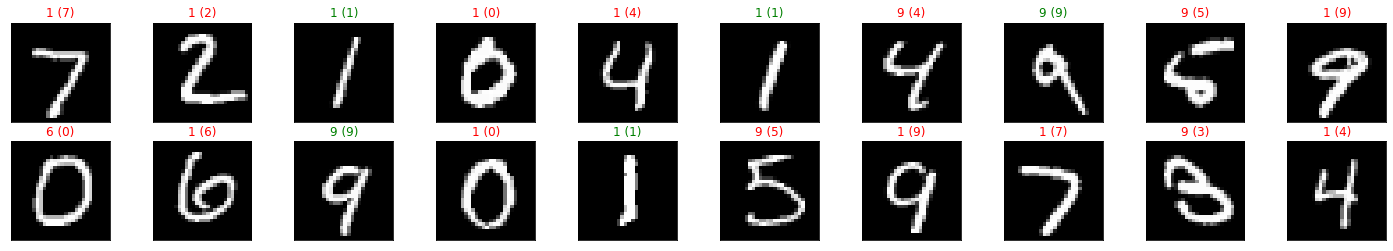

In [51]:
# Prepare to save input and output of the model and prediction for hardware testing 

# initialize lists to monitor test accuracy
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval() # prep model for evaluation

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# forward pass: compute predicted outputs by passing inputs to the model
outputs = model(images)
# convert raw output to predicted class
# for i in range(outputs[0].shape[0]):
print(outputs)
_, preds = torch.max(outputs[6], 1) # dim = 1 = maximum in each row  
print(preds)
# compare predictions to true label

correct = np.squeeze(preds.eq(labels.data.view_as(preds)))
# calculate test accuracy for each object class

print(correct)
print(type(correct))

for i in range(len(preds)):
    label = labels.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (class_total[i]))
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

# prep images for display
images = images.numpy()
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

In [ ]:
# Save input and output of the model and prediction for hardware testing 

import pandas as pd
from google.colab import files

# 10 correct predictions and 1 wrong prediction 
! mkdir test_images
! cd test_images

for i in range(11):
  print("{}: Correct prediction? [{}] (label: {}, predicted: {})".format(i, str(correct[i].item()), str(labels[i].item()), str(preds[i].item())))
  img = images[i].squeeze().reshape(1, -1)
  pd.DataFrame(img).to_csv('test_img{}.dat'.format(i), index=False, header=False)
  files.download('test_img{}.dat'.format(i))

mkdir: cannot create directory ‘test_images’: File exists
0: Correct prediction? [True] (label: 4, predicted: 7)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1: Correct prediction? [True] (label: 0, predicted: 2)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2: Correct prediction? [True] (label: 4, predicted: 1)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3: Correct prediction? [True] (label: 6, predicted: 0)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

4: Correct prediction? [True] (label: 5, predicted: 4)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

5: Correct prediction? [True] (label: 4, predicted: 1)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

6: Correct prediction? [True] (label: 0, predicted: 4)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

7: Correct prediction? [True] (label: 8, predicted: 9)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

8: Correct prediction? [False] (label: 5, predicted: 6)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

9: Correct prediction? [True] (label: 8, predicted: 9)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

10: Correct prediction? [True] (label: 6, predicted: 0)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# list(model.fc1.parameters())

In [ ]:
# Test loss and accuracy

# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval() # prep model for evaluation
for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.061030

Test Accuracy of     0: 98% (969/980)
Test Accuracy of     1: 99% (1127/1135)
Test Accuracy of     2: 97% (1011/1032)
Test Accuracy of     3: 98% (992/1010)
Test Accuracy of     4: 97% (962/982)
Test Accuracy of     5: 97% (872/892)
Test Accuracy of     6: 97% (938/958)
Test Accuracy of     7: 97% (999/1028)
Test Accuracy of     8: 97% (945/974)
Test Accuracy of     9: 97% (984/1009)

Test Accuracy (Overall): 97% (9799/10000)


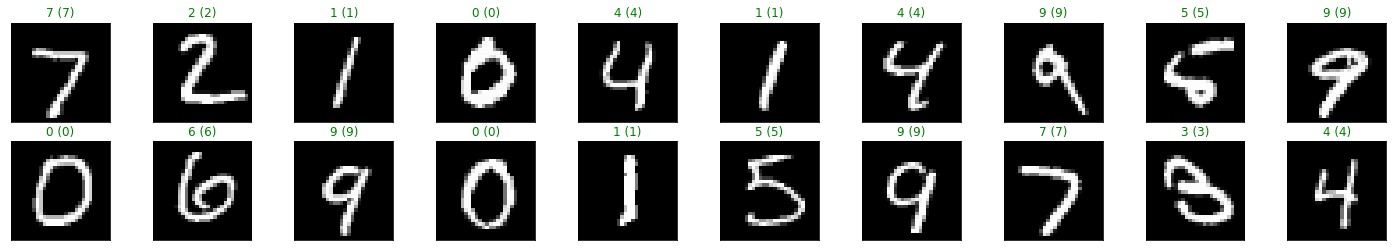

In [ ]:
# Visually check the accuracy

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

In [ ]:
! mkdir save_parameters
! cd save_parameters

fc1_double_weights = model.fc1.weight.detach().numpy() 
fc1_double_bias = model.fc1.bias.detach().numpy() 

pd.DataFrame(fc1_double_weights).to_csv('fc1_784x10_double_weights.dat', index=False, header=False)
pd.DataFrame(fc1_double_bias).to_csv('fc1_784x10_double_bias.dat', index=False, header=False)

files.download('fc1_784x10_double_weights.dat')
files.download('fc1_784x10_double_bias.dat')

mkdir: cannot create directory ‘save_parameters’: File exists


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>